In [31]:
#!pip install tscv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

- Collect average transaction size for a credit card
- Average longitude and latitude of transactions
- Average time of transaction
- 

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
folder_location = '/content/gdrive/MyDrive/Colab Notebooks/DS4400: ML Project/' 
# training = pd.read_csv(folder_location + 'fraudTrain.csv')  
# testing = pd.read_csv(folder_location + 'fraudTest.csv')
X_train = pd.read_csv(folder_location + 'X_train_eng.csv').drop(["Unnamed: 0", "is_fraud"], axis=1)
y_train = pd.read_csv(folder_location + 'y_train.csv').drop(["Unnamed: 0"], axis=1)  
X_test = pd.read_csv(folder_location + 'X_test_agg.csv').drop(["Unnamed: 0", "is_fraud"], axis=1)  
y_test = pd.read_csv(folder_location + 'y_test.csv').drop(["Unnamed: 0"], axis=1)   


In [ ]:
testing.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [1]:
# visualize the target variable - clearly our data is highly imbalanced and something must be done to fix this issue
g = sns.countplot(testing['is_fraud'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

NameError: ignored

In [16]:
from time import mktime
from sklearn.preprocessing import MinMaxScaler

def normalize_features(X_train, X_test):
  scaler = MinMaxScaler()
  X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
  X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_train.columns)
  return X_train_scaled, X_test_scaled

def engineer_datetime(df):
  df["datetime"] = df["trans_date_trans_time"].apply(pd.to_datetime)
  df["hour"] = df["datetime"].dt.hour
  df["day"] = df["datetime"].dt.day
  df["month"] = df["datetime"].dt.month
  df["unix_purchase_time"] = df["datetime"].apply(lambda dt: mktime(dt.timetuple()))
  dob_dt = df["dob"].apply(pd.to_datetime)
  dob_year = dob_dt.dt.year 
  df["dob_year"] = dob_year
  df["unix_dob"] = dob_dt.apply(lambda dt: mktime(dt.timetuple()))
  df = df.drop(["trans_date_trans_time", "dob"], axis=1)
  return df

def engineer_features(df):
  df = engineer_datetime(df)
  df = df.drop(["state", "city", "Unnamed: 0", "merchant", "first", "last", "street", "zip", "job", "unix_time"], axis=1)
  df["is_man"] = df["gender"].apply(lambda x: 0 if x == "F" else 1)
  df = df.drop("gender", axis=1)
  df.reset_index(inplace=True)
  #df = pd.DataFrame(df, dtype={'amt': float, 'lat': float, 'long': float, 'city_pop': float, 'merch_lat': float, 'merch_long': float})
  df = df.astype({'amt': float, 'lat': float, 'long': float, 'city_pop': float, 'merch_lat': float, 'merch_long': float})
  obj_df = df.select_dtypes(include=['object']).copy()
  obj_df_encoded = pd.get_dummies(obj_df, columns=["category"], prefix=["category"])
  df = df.drop(["category"], axis=1)
  obj_df_encoded.reset_index(inplace=True)
  df = pd.concat([df,obj_df_encoded],axis=1).drop("index", axis=1)
  df = df.loc[:,~df.columns.duplicated()]
  means = df.apply(concat_averages, frame=df, axis=1)
  df = df.merge(means, left_on='trans_num', right_on='trans_num')
  df.drop(['datetime', 'cc_num', 'trans_num'], axis=1, inplace=True)
  return df


def f(x):
    d = {}
    d['amt_mean'] = x['amt'].mean()
    d['amt_std'] = x['amt'].std()
    d['amt_count'] = x['amt'].count()
    d['merch_lat_mean'] = x['merch_lat'].mean()
    d['merch_lat_std'] = x['merch_lat'].std()
    d['merch_long_mean'] = x['merch_long'].mean()
    d['merch_long_std'] = x['merch_long'].std()
    d['is_fraud_mean'] = x['is_fraud'].mean()
    d['is_fraud_std'] = x['is_fraud'].std()
    d['previous_frauds_for_cc_num'] = d['amt_count'] * d['is_fraud_mean']
    return pd.Series(d, index=['amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num'])

def concat_averages(row, frame):
  date = row['datetime']
  cc_num = row['cc_num']
  frame_before_date = frame.loc[ (frame["cc_num"] == cc_num) & (frame['datetime'] < date)].copy()
  frame_before_date.drop(columns=['city_pop', 'lat', 'long'], inplace=True)
  cc_averages = frame_before_date.groupby("cc_num").apply(f)
  cc_averages = cc_averages.fillna(0)
  indices = ['amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num']
  if len(cc_averages.values) == 0:
    zeros = np.zeros(len(indices))
    series = pd.Series(zeros, index=indices)
  else:
    series = pd.Series(cc_averages.values[0], index=indices)
  series['trans_num'] = row['trans_num']
  return series


In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

y_train = training["is_fraud"]
X_train = training.drop(["is_fraud"], axis = 1)

# summarize class distribution
print("Before undersampling: ", Counter(y_train))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy=.1)

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print("After undersampling: ", Counter(y_train_under))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Before undersampling:  Counter({0: 1289169, 1: 7506})
After undersampling:  Counter({0: 75060, 1: 7506})


In [24]:
#PART 2
# import SVM libraries 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split


x_train_unused, X_test, y_train, y_test = train_test_split(testing.drop(["is_fraud"], axis=1), testing["is_fraud"], test_size = 0.1)

X_train_under_df = pd.DataFrame(X_train_under, columns=training.drop(["is_fraud"], axis=1).columns)
X_test_df = pd.DataFrame(X_test, columns=training.drop(["is_fraud"], axis=1).columns)
X_train_under_df['is_fraud'] = y_train_under
print(X_train_under_df.shape, X_test_df.shape)
X_train_under_df = engineer_features(X_train_under_df)
X_test_df['is_fraud'] = y_test
X_test_df = engineer_features(X_test_df)

X_train_under_df.drop('is_fraud', axis=1, inplace=True)
X_test_df.drop('is_fraud', axis=1, inplace=True)

X_train_under_df.head()

NameError: ignored

In [ ]:
def create_aggregated_df_to_apply_to_test(train_df):
  lat_long_df = train_df[['lat', 'long', 'amt_count']]
  lat_long_df_agg = lat_long_df.groupby(['lat', 'long']).agg('max')
  lat_long_df_agg.set_index(['amt_count'], append=True, inplace=True)
  lat_long_df_agg.head()
  indices = ['lat', 'long', 'amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num']
  cc_averages_by_lat = train_df[indices]
  cc_averages_by_lat.set_index(['lat', 'long', 'amt_count'], inplace=True)
  df_with_maxes = pd.merge(lat_long_df_agg, cc_averages_by_lat, left_index=True, right_index=True, how="inner")
  df_with_maxes.reset_index(level='amt_count', inplace=True)
  return df_with_maxes

agg_df_to_apply_to_test = create_aggregated_df_to_apply_to_test(X_train_under_df)


In [ ]:
def map_aggregations(row, frame):
  lat = row['lat']
  long = row['long']
  if (lat, long) not in frame.index:
    return row
  else:
    frame_row = frame.loc[(lat, long)]
    if row['amt_count'] == 0:
      row['amt_mean'] = frame_row['amt_mean']
      row['amt_std'] = frame_row['amt_std']
      row['amt_count'] = frame_row['amt_count']
      row['merch_lat_mean'] = frame_row['merch_lat_mean']
      row['merch_lat_std'] = frame_row['merch_lat_std']
      row['merch_long_mean'] = frame_row['merch_long_mean']
      row['merch_long_std'] = frame_row['merch_long_std']
      row['is_fraud_mean'] = frame_row['is_fraud_mean']
      row['is_fraud_std'] = frame_row['is_fraud_std']
      row['previous_frauds_for_cc_num'] = frame_row['previous_frauds_for_cc_num']
      return row
    else:
      test_count = row['amt_count']
      frame_row_count = frame_row['amt_count']

      row['amt_mean'] = combine_means(row['amt_mean'], frame_row['amt_mean'], test_count, frame_row_count)
      row['amt_std'] = combine_std(row['amt_std'], frame_row['amt_std'], test_count, frame_row_count)
      row['amt_count'] = test_count + frame_row_count
      row['merch_lat_mean'] = combine_means(row['merch_lat_mean'], frame_row['merch_lat_mean'], test_count, frame_row_count)
      row['merch_lat_std'] = combine_std(row['merch_lat_std'], frame_row['merch_lat_std'], test_count, frame_row_count)
      row['merch_long_mean'] = combine_means(row['merch_long_mean'], frame_row['merch_long_mean'], test_count, frame_row_count)
      row['merch_long_std'] = combine_std(row['merch_long_std'], frame_row['merch_long_std'], test_count, frame_row_count)
      row['is_fraud_mean'] = combine_means(row['is_fraud_mean'], frame_row['is_fraud_mean'], test_count, frame_row_count)
      row['is_fraud_std'] = combine_std(row['is_fraud_std'], frame_row['is_fraud_std'], test_count, frame_row_count)
      row['previous_frauds_for_cc_num'] = frame_row['previous_frauds_for_cc_num'] + row['previous_frauds_for_cc_num']
      return row

def combine_means(mean1, mean2, n1, n2):
  return (mean1 * n1 + mean2 * n2) / (n1 + n2)

def combine_std(std1, std2, n1, n2):
  var1 = (std1 ** 2) / n1
  var2 = (std2 ** 2) / n2
  return np.sqrt((var1 + var2) / 2)   


In [ ]:
def apply_aggregation_df_to_test(test_df, agg_df):
  return test_df.apply(map_aggregations, frame=agg_df, axis=1)

X_test_df_agg = apply_aggregation_df_to_test(X_test_df, agg_df_to_apply_to_test)

In [ ]:
def add_blank_columns(df_train, df_test):
  for column in df_train.columns:
    if column not in df_test.columns:
      df_test[column] = 0
  for column2 in df_test.columns:
    if column2 not in df_train.columns:
      df_train[column2] = 0
  return df_train, df_test
##X_train_under_df, X_test_df = add_blank_columns(X_train_under_df, X_test_df)

In [17]:
# scaling features 

X_train_scaled_df, X_test_scaled_df = normalize_features(X_train, X_test)
X_train_scaled_df.to_csv(folder_location + "X_train_aggregated_and_scaled.csv")
X_test_scaled_df.to_csv(folder_location + "X_test_aggregated_and_scaled.csv")

In [73]:
X_train_scaled_df.tail()

,amt,lat,long,city_pop,merch_lat,merch_long,hour,day,month,dob_year,is_man,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,amt_mean,amt_std,amt_count,merch_lat_mean,merch_lat_std,merch_long_mean,merch_long_std,is_fraud_mean,is_fraud_std,previous_frauds_for_cc_num
1296670,0.000503,0.379084,0.544346,0.000081,0.367421,0.551347,0.521739,0.666667,0.454545,0.456790,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044096,0.036271,0.484305,0.561719,0.415637,0.322933,0.435419,0.005952,0.108820,0.473684
1296671,0.001751,0.412281,0.902174,0.000026,0.410026,0.886727,0.521739,0.666667,0.454545,0.679012,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070625,0.042853,0.169763,0.584750,0.426240,0.533288,0.439388,0.015094,0.172596,0.421053
1296672,0.003625,0.276699,0.612486,0.000301,0.300969,0.617133,0.521739,0.666667,0.454545,0.530864,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045493,0.048668,0.662716,0.489832,0.409624,0.363194,0.439553,0.005317,0.102868,0.578947
1296673,0.002553,0.499837,0.646029,0.000379,0.490098,0.636080,0.521739,0.666667,0.454545,0.691358,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066802,0.033738,0.647982,0.645154,0.415553,0.382865,0.442897,0.003955,0.088779,0.421053
1296674,0.000114,0.553210,0.530050,0.000067,0.568003,0.526323,0.521739,0.666667,0.454545,0.876543,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048113,0.027980,0.483985,0.682423,0.422747,0.314591,0.446493,0.005295,0.102664,0.421053


In [72]:
X_test_scaled_df.head()

,amt,lat,long,city_pop,merch_lat,merch_long,hour,day,month,dob_year,is_man,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,amt_mean,amt_std,amt_count,merch_lat_mean,merch_lat_std,merch_long_mean,merch_long_std,is_fraud_mean,is_fraud_std,previous_frauds_for_cc_num
0,0.000064,0.298692,0.867121,0.114727,0.308536,0.857102,0.521739,0.666667,0.454545,0.543210,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.049069,0.043602,0.499680,0.505779,0.411062,0.512953,0.445257,0.007692,0.123596,0.631579
1,0.000996,0.434867,0.565239,0.000096,0.421239,0.568699,0.521739,0.666667,0.454545,0.814815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.042621,0.061434,0.668802,0.600080,0.418344,0.335279,0.449110,0.006705,0.115440,0.736842
2,0.001391,0.442414,0.942836,0.011860,0.442800,0.927345,0.521739,0.666667,0.454545,0.567901,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062305,0.045513,0.825112,0.605235,0.416657,0.557376,0.440261,0.002717,0.073635,0.368421
3,0.002040,0.183058,0.868312,0.018834,0.201817,0.860288,0.521739,0.666667,0.454545,0.777778,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.040411,0.063186,0.488469,0.425210,0.416574,0.513605,0.437670,0.000000,0.000000,0.000000
4,0.000076,0.519129,0.825355,0.000379,0.534860,0.810131,0.521739,0.666667,0.454545,0.382716,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.044441,0.038202,0.651185,0.658598,0.412812,0.488217,0.433355,0.005411,0.103770,0.578947


In [ ]:
print(np.isnan(X_train_scaled_df.any())) #and gets False
print(np.isfinite(X_train_scaled_df.all()))
print(np.isnan(np.min(X_train_scaled_df)))

False
True
False


In [13]:
## Feature Research - Running Random Forest for Feature Importances

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Text(0.5, 0, 'Random Forest Feature Importance')

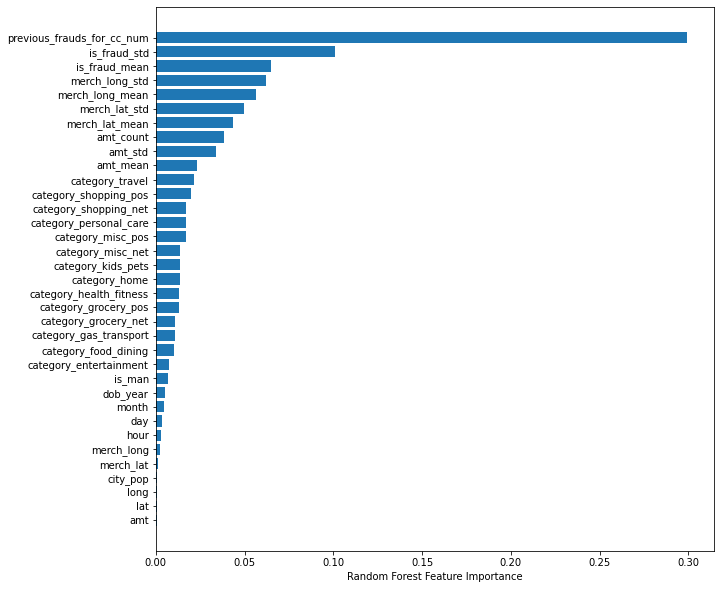

In [18]:
rf.feature_importances_
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns)
feature_importances.to_csv(folder_location + "RF_feature_importances.csv")
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [82]:
## Perform cross validation to get preliminary best models
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from tscv import GapWalkForward
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

def perform_cross_validation(metrics_df, model, model_name, X_training, y_training):
  tscv = GapWalkForward(n_splits=10, gap_size=0, test_size=10000)

  g_means = []
  f1s = []
  f2s = []
  precisions = []
  recalls = []
  accuracies = []
  errors = []

  for train_index, test_index in tscv.split(X_training):
    X_train, X_test = X_training.iloc[train_index], X_training.iloc[test_index]
    y_train, y_test = y_training.iloc[train_index], y_training.iloc[test_index]

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    model.fit(X_train, y_train.values.ravel())
    predictions = model.predict(X_test)

    f1 = f1_score(y_test, predictions)
    f2 = fbeta_score(y_test, predictions, beta=2)

    # print(confusion_matrix(y_test, predictions))
    # print(classification_report(y_test, predictions))

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    recall = tp / (tp + fn)
    specificity = tn / (fp + tn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)

    g_mean = np.sqrt(recall * specificity)

    f1s.append(f1)
    f2s.append(f2)
    g_means.append(g_mean)
    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    errors.append(1- accuracy)
  
  print(f1s, f2s, g_means, precisions, recalls)
  metrics_df.loc[model_name] = [np.mean(f1s), np.mean(f2s), np.mean(g_means), np.mean(recalls), np.mean(precisions), np.mean(accuracies), np.mean(errors)]

  return model, metrics_df

def compare_models(models, model_names, X_training, y_training, X_testing, y_testing):
  cross_validation_model_scores = pd.DataFrame(data=None, columns = ["Model Name", "F1-Score", "F2-Score", "G-Mean", "Recall for 1", "Precision for 1", "Accuracy", "Error"])
  cross_validation_model_scores.set_index('Model Name', inplace=True)
  for i in range(len(models)):
    model, cross_validation_model_scores = perform_cross_validation(cross_validation_model_scores, models[i], model_names[i], X_training, y_training)
    predictions = model.predict(X_testing)
    print(confusion_matrix(y_testing, predictions))
    print(classification_report(y_testing, predictions))
  return cross_validation_model_scores

model_names = ["LogRegression", "LDA", "Naive Bayes", "Decision Trees", "kNN", "SVM", "Random Forest", "XGBoost", "AdaBoost"]
some_model_names = ["LogReg", "Random Forest", "AdaBoost", "Decision Trees", "SVC"]
some_models = [LogisticRegression(random_state=0, max_iter=2000), RandomForestClassifier(n_estimators=100, random_state=0), AdaBoostClassifier(n_estimators = 100, random_state=0), DecisionTreeClassifier(random_state=0), SVC(random_state=0)]

compare_models(some_models, some_model_names, X_train_scaled_df.tail(300000), y_train.tail(300000), X_test_scaled_df.head(100000), y_test.head(100000))

(200000, 35) (10000, 35) (200000, 1) (10000, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


(210000, 35) (10000, 35) (210000, 1) (10000, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


(220000, 35) (10000, 35) (220000, 1) (10000, 1)
(230000, 35) (10000, 35) (230000, 1) (10000, 1)
(240000, 35) (10000, 35) (240000, 1) (10000, 1)
(250000, 35) (10000, 35) (250000, 1) (10000, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


(260000, 35) (10000, 35) (260000, 1) (10000, 1)
(270000, 35) (10000, 35) (270000, 1) (10000, 1)
(280000, 35) (10000, 35) (280000, 1) (10000, 1)
(290000, 35) (10000, 35) (290000, 1) (10000, 1)
[0.0, 0.0, 0.03125, 0.26315789473684215, 0.0, 0.0, 0.3076923076923077, 0.06666666666666667, 0.2857142857142857, 0.015037593984962407] [0.0, 0.0, 0.019762845849802372, 0.18450184501845018, 0.0, 0.0, 0.2173913043478261, 0.04273504273504274, 0.19999999999999996, 0.00945179584120983] [0.0, 0.0, 0.12598815766974242, 0.3922125298566029, 0.0, 0.0, 0.4264014327112209, 0.18569533817705186, 0.408248290463863, 0.08703882797784893] [nan, nan, 1.0, 0.9090909090909091, 0.0, nan, 1.0, 1.0, 1.0, 1.0] [0.0, 0.0, 0.015873015873015872, 0.15384615384615385, 0.0, 0.0, 0.18181818181818182, 0.034482758620689655, 0.16666666666666666, 0.007575757575757576]
[[99595     3]
 [  351    51]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99598
           1       0.94     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


(220000, 35) (10000, 35) (220000, 1) (10000, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


(230000, 35) (10000, 35) (230000, 1) (10000, 1)
(240000, 35) (10000, 35) (240000, 1) (10000, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


(250000, 35) (10000, 35) (250000, 1) (10000, 1)
(260000, 35) (10000, 35) (260000, 1) (10000, 1)
(270000, 35) (10000, 35) (270000, 1) (10000, 1)
(280000, 35) (10000, 35) (280000, 1) (10000, 1)
(290000, 35) (10000, 35) (290000, 1) (10000, 1)
[0.08163265306122448, 0.0, 0.0, 0.2666666666666667, 0.0, 0.03571428571428572, 0.3823529411764706, 0.2424242424242424, 0.3157894736842105, 0.02985074626865672] [0.05263157894736842, 0.0, 0.0, 0.18518518518518517, 0.0, 0.02262443438914027, 0.2789699570815451, 0.16666666666666666, 0.22388059701492538, 0.018867924528301886] [0.20628424925175867, 0.0, 0.0, 0.3922322702763681, 0.0, 0.13483997249264842, 0.4861724348043977, 0.3713906763541037, 0.4330127018922193, 0.12309149097933274] [1.0, nan, nan, 1.0, nan, 1.0, 1.0, 1.0, 1.0, 1.0] [0.0425531914893617, 0.0, 0.0, 0.15384615384615385, 0.0, 0.01818181818181818, 0.23636363636363636, 0.13793103448275862, 0.1875, 0.015151515151515152]
[[99598     0]
 [  349    53]]
              precision    recall  f1-score   s

,F1-Score,F2-Score,G-Mean,Recall for 1,Precision for 1,Accuracy,Error
Model Name,,,,,,,
LogReg,0.096952,0.067384,0.162558,0.056026,NaN,0.99448,0.00552
Random Forest,0.815308,0.741542,0.834048,0.700688,0.991844,0.99805,0.00195
AdaBoost,0.642314,0.566746,0.718130,0.529070,0.883650,0.99671,0.00329
Decision Trees,0.771361,0.773939,0.879693,0.779831,0.781888,0.99757,0.00243
SVC,0.135443,0.094883,0.214702,0.079153,NaN,0.99460,0.00540


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score for undersampled data:  0.5640515583681343


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test.iloc[0:50000], pred_under))
print(classification_report(y_test.iloc[0:50000], pred_under))
print("--------------------------------------------------------")
print(confusion_matrix(y_train.iloc[0:50000], pred_train))
print(classification_report(y_train.iloc[0:50000], pred_train))

[[49674   127]
 [  173    26]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49801
           1       0.17      0.13      0.15       199

    accuracy                           0.99     50000
   macro avg       0.58      0.56      0.57     50000
weighted avg       0.99      0.99      0.99     50000

--------------------------------------------------------
[[47094  2458]
 [    0   448]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     49552
           1       0.15      1.00      0.27       448

    accuracy                           0.95     50000
   macro avg       0.58      0.98      0.62     50000
weighted avg       0.99      0.95      0.97     50000



In [ ]:


ada = AdaBoostClassifier(n_estimators = 100, random_state=0)
ada.fit(X_train_scaled_df, y_train_under)
pred_test = ada.predict(X_test_scaled_df)
pred_train = ada.predict(X_train_scaled_df)
print(classification_report(y_test, pred_test))
print(classification_report(y_train_under, pred_train))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     55381
           1       0.07      0.78      0.13       191

    accuracy                           0.97     55572
   macro avg       0.54      0.87      0.56     55572
weighted avg       1.00      0.97      0.98     55572

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     75060
           1       0.93      0.88      0.91      7506

    accuracy                           0.98     82566
   macro avg       0.96      0.94      0.95     82566
weighted avg       0.98      0.98      0.98     82566



In [ ]:
print(confusion_matrix(y_test, pred_test))

[[53490  1891]
 [   42   149]]
